# Ground state in the source well using imaginary time evolution

In [48]:
import math
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
from scipy import fftpack

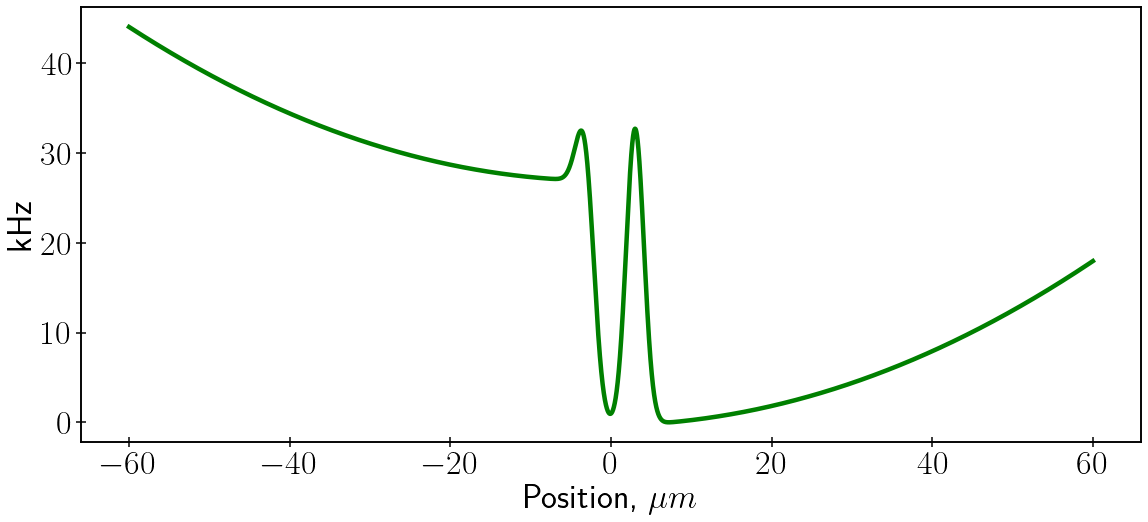

In [49]:
x,y= np.loadtxt("potential_landscape.txt", delimiter = '\t', unpack=True)
large = 40; med = 34; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
plt.rcParams.update(params)
f = plt.figure()
ax = f.gca()
plt.xlabel("Position, "+r"$\mu m $",fontweight='bold')  # Set X-axis label
plt.ylabel(r"kHz")
plt.plot(x,y,linewidth = 4.5,color="green")
f.set_figwidth(19)
f.set_figheight(8)
for spine in ax.spines.values():
    spine.set_linewidth(1.9)
    ax = f.gca()
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1.5, color="k")
#ax.axhline(0, color='black')
#ax.axvline(0, color='black')
plt.savefig('potential_landscape.png', dpi=300)
plt.show()

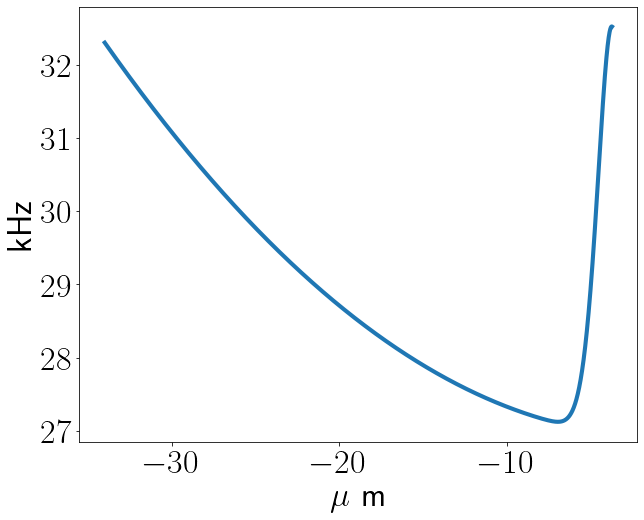

In [50]:
def extract_source_well_potential(position,potential):
    
    # Position where the gate well starts.
    gate_well_start_index = -34
    # Position where the gate well ends.
    gate_well_end_index   = -3.7
    # Extracts the gate well position.
    well_position = position[np.where((position > gate_well_start_index) & (position < gate_well_end_index))]
    # Extract the corresponding potential values for the gate well.
    well_potential = potential[np.where(position == well_position[0])[0][0]:np.where(position == well_position[-1])[0][0]+1]
    
    return [well_position,well_potential]

source_well_position  = extract_source_well_potential(x,y)[0]
source_well_potential = extract_source_well_potential(x,y)[1]
f = plt.figure()
plt.plot(source_well_position,source_well_potential,linewidth=4.1)
plt.xlabel(r"$\mu$ m")
plt.ylabel(r"kHz")
f.set_figwidth(10)
f.set_figheight(8)
#plt.savefig('source_well.png', dpi=300)
plt.show()

Minimum of the gate well, =  0.0 , location, =  0.0


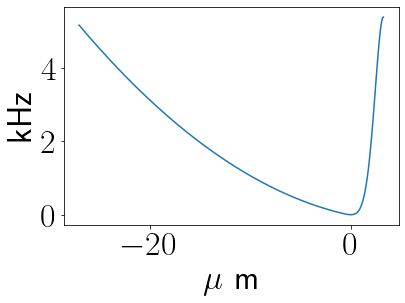

In [51]:
source_well_potential_min_index = [np.where(source_well_potential == min(source_well_potential))][0][0][0]
source_well_potential = source_well_potential - min(source_well_potential)
source_well_position = source_well_position-source_well_position[source_well_potential_min_index]
# Prints the new location of the potential minima and its value.
print("Minimum of the gate well, = ", min(source_well_potential), ", location, = ",
      source_well_position[[np.where(source_well_potential == min(source_well_potential))][0][0][0]])
plt.plot(source_well_position,source_well_potential)
plt.xlabel(r"$\mu$ m")
plt.ylabel(r"kHz")
plt.show()

In [52]:
"""
The potential is in kHz units. It is converted to SI units
by multiplying 10^3 * h.
"""
PI = np.pi
H_BAR = 6.626*10**(-34)/(2*PI)
external_potential = source_well_potential*(10**3)*2*PI*(H_BAR) # J
xs = source_well_position*1.e-6 # m

N  = len(external_potential)
r""" Rb87 parameters """
M   = 1.4192261*10**(-25) # kg
a_s = 98.006*5.29*10**(-11) # m https://journals.aps.org/pra/abstract/10.1103/PhysRevA.87.053614
trap_frequency = 918
trap_length = np.sqrt(H_BAR/(M*trap_frequency)) # m
A = PI*trap_length**2
N_atom = 20*10**3
g   = (4*PI*H_BAR**2*a_s)/(A*M)


# Length of the space interval.
L  = len(xs)#(max(xs)-min(xs))
# Increment in the space interval.
dx = np.abs(xs[1]-xs[0])
# Increment in momentum space interval.
dk = (2*PI)/L

# Trapping frequency of the harmionic oscillator.
OMEGA = 5748.55# 4918.11
def V_external(x):
    return external_potential
    #return 0.5*M*(OMEGA**2)*(x)**2

# H(k)
def Hamiltonian_k(p):
    return p**2/(2*M)

# H(x).
def Hamiltonian_x(x,psi):
    #g = 0
    return V_external(x)+N_atom*g*np.abs(psi)**2

In [53]:
V_external(xs)

array([3.42783592e-30, 3.42757752e-30, 3.42731913e-30, ...,
       3.57343373e-30, 3.57330522e-30, 3.57316698e-30])

In [54]:
g

2.007624893595827e-39

In [55]:
# Momentum space discretization.
k = np.hstack([np.arange(0,N/2), np.arange(-N/2,0)])*dk
E_k = (H_BAR**2*k**2)/(2*M)

In [56]:
# The exact ground state of a quantum harmonic oscillator.
def psi_0(x):
    return (((M*OMEGA/(PI*H_BAR)))**(1/4))*np.exp(-(M*OMEGA/(2*H_BAR))*x**2)

In [57]:
r"""

A custom normalization function is needed to
ensure correct normalization done using a sum instead of an integral.

"""
# Normalize the wavefunction in real space.
def normalize_x(wavefunction_x):
    return wavefunction_x/(np.sqrt(np.sum(np.abs(wavefunction_x)**2)*dx))
# Normalize the wavefunction in momentum space.
def normalize_k(wavefunction_k):
    return wavefunction_k/(np.sqrt(np.sum(np.abs(wavefunction_k)**2)*dk))

    
def imaginary_time_evolution(dt,total_iterations):    
    
    r"""
    
    Input : time interval: dt and total number of iterations to be performed.
    Output: an ordered pair of imaginary time evolved wavefunction and ground
            state energy calculated using the obtained wavefunction.
    
    """
    # Initial guess for the wavefunction.
    psi_initial = np.ones(N)
    # Normalize the initial guess wavefunction.
    psi_initial = normalize_x(psi_initial) 
    
    #psi_k    = fftpack.fft(psi_initial)
    psi_x = psi_initial
    
    for i in range(total_iterations):

        psi_x = np.exp(-Hamiltonian_x(xs,psi_x) * dt/(2*H_BAR)) * psi_x
        psi_x = normalize_x(psi_x)
        psi_k = fftpack.fft(psi_x)
        psi_k = np.exp(-(E_k * dt)/H_BAR) * psi_k
        psi_x = fftpack.ifft(psi_k)
        psi_x = np.exp(-Hamiltonian_x(xs,psi_x) * dt/(2*H_BAR)) * psi_x
        psi_x = normalize_x(psi_x)        
        
        
        
        r"""
        psi_k = np.exp(-(E_k * dt)/(2*H_BAR)) * psi_k
        psi_x = fftpack.ifft(psi_k)
        psi_x = np.exp(-Hamiltonian_x(xs,psi_x) * dt/H_BAR) * psi_x
        psi_k = fftpack.fft(psi_x)
        psi_k = np.exp(-(E_k * dt)/(2*H_BAR)) * psi_k
        psi_x = fftpack.ifft(psi_k)
        psi_x = normalize_x(psi_x)
        psi_k = fftpack.fft(psi_x)"""
    
    # Taking the absolute value to remove the relative phase in the wavefunction.
    #psi_x = np.abs(fftpack.ifft(psi_k))
    psi_x = normalize_x(psi_x)
    potential_energy = np.sum(V_external(xs)*np.abs(psi_x)**2)*dx
    
    psi_k = fftpack.fft(psi_x)
    psi_k = normalize_k(psi_k)
    psi_k = fftpack.fftshift(psi_k)
    
    kinetic_energy   = np.sum(E_k*np.abs(psi_k)**2)*dk
    
    ground_state_energy = kinetic_energy + potential_energy
        
    return psi_x, ground_state_energy

In [58]:
psi_ITE = imaginary_time_evolution(10**(-5),1000)

In [59]:
print("Ground state energy of the source well = ", psi_ITE[1]/(H_BAR*OMEGA),"(in units of h_bar)")

psi_ITE_data_file = open("ground_state_wavefunction_source_well.txt","w")
for i in range(N):
    psi_ITE_data_file.write(str(xs[i])+"\t"+str(psi_ITE[0][i].real)+"\n")
psi_ITE_data_file.close()

Ground state energy of the source well =  0.9827507677706647 (in units of h_bar)


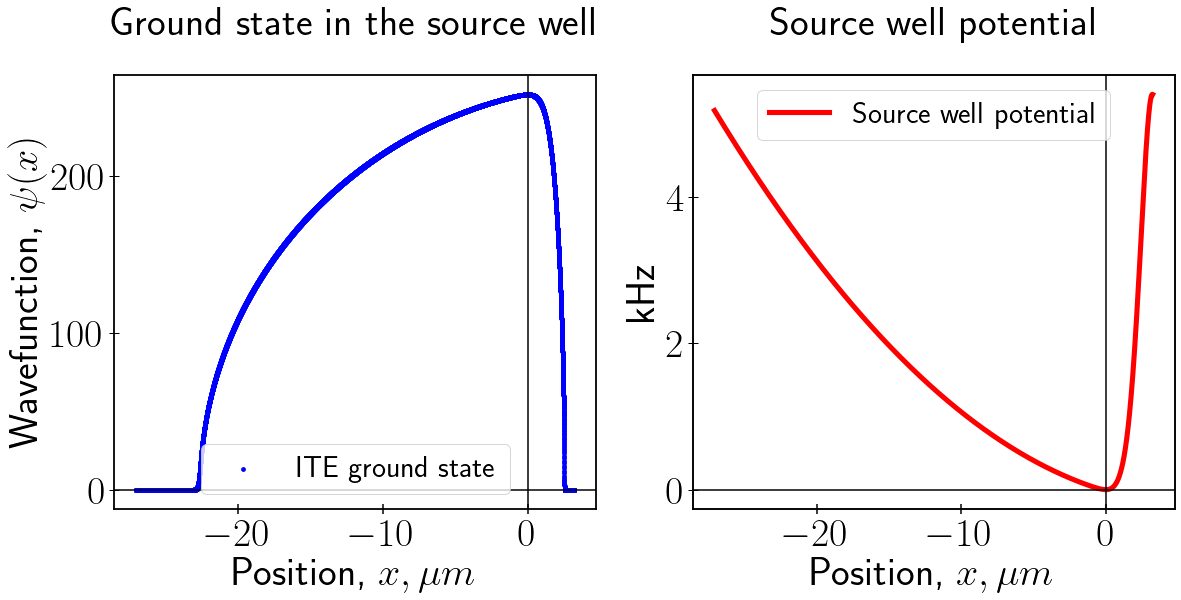

In [60]:
large = 40; med = 30; small = 20
params = {'axes.titlesize': large,
          'axes.titlepad' : large,
          'legend.fontsize': med,
          'axes.labelsize': large ,
          'axes.titlesize': large ,
          'xtick.labelsize': large ,
          'ytick.labelsize': large ,
          'figure.titlesize': large}
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
plt.rcParams.update(params)
f = plt.figure()
plt.figure(1)

plt.subplot(121)
#plt.plot(xs/(1.e-6),normalize_x(psi_0(xs)),label="Exact ground state of QHO",linewidth = 3.1)
plt.scatter(xs/(1.e-6),psi_ITE[0].real,s=14.1,color='blue',label="ITE ground state")
#plt.xlim([min(xs)/(1.e-6),max(xs)/(1.e-6)])
#plt.ylim([300,500])
plt.legend()
plt.title('Exact wavefunction')
plt.xlabel("Position, "+r"$x ,\mu m $",fontweight='bold')  # Set X-axis label
plt.xticks(fontweight='bold')
plt.ylabel("Wavefunction, "+r"$\psi(x)$",fontweight='bold')  # Set Y-axis label
plt.yticks(fontweight='bold')
ax = f.gca()
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1, color="k")
ax.axhline(0, color='black')
ax.axvline(0, color='black')
plt.title('Ground state in the source well')
#plt.grid(linestyle='--', alpha=0.5)
for spine in ax.spines.values():
    spine.set_linewidth(1.8)
    
plt.subplot(122)
# Plots the gate well potential.
#plt.xlabel("Position, "+r"$x ,\mu m $",fontweight='bold')  # Set X-axis label
#plt.ylabel(r"kHz")

# Plots the harmonic oscillator potential.
#plt.scatter(xs/(1.e-6),0.5*M*OMEGA**2*(xs)**2/(10**3*2*PI*H_BAR),s = 5,label="Harmonic potential")
plt.plot(xs/(1.e-6),source_well_potential,color="red",linewidth = 5.1,label="Source well potential")
plt.legend()
plt.xlabel("Position, "+r"$x ,\mu m $",fontweight='bold')  # Set X-axis label
plt.ylabel(r"kHz")

plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.title('Source well potential')
ax = f.gca()
ax.tick_params(axis="x", direction="inout", length=10, width=1.5, color="k")
ax.tick_params(axis="y", direction="inout", length=10, width=1, color="k")
ax.axhline(0, color='black')
ax.axvline(0, color='black')
f.set_figwidth(19)
f.set_figheight(8)
for spine in ax.spines.values():
    spine.set_linewidth(1.9)
plt.show()

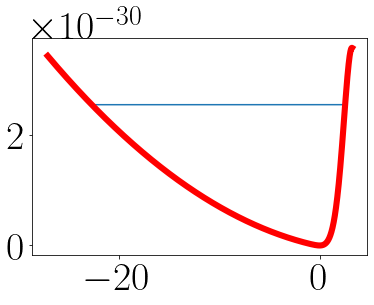

In [61]:
chemical_potential = external_potential+g*N_atom*np.abs(psi_ITE[0])**2
plt.plot(source_well_position,chemical_potential)
plt.plot(source_well_position,source_well_potential*10**3*2*PI*H_BAR,color="red",linewidth = 6.1)
plt.show()